# PS4 #13 - Semi-parametric GP models 

In [1]:
import numpy as np
import gpytorch
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6) # Default figsize
np.random.seed(42)

In this problem, we present yet another variant of the case study of PS02, Problem 4, where we modeled
Stribeck’s law of friction with generalized linear regression. We now propose to model it with a GP.

## Setup
We reuse the functions from PS02, Problem 04.

We assume that we have access to a physical testbed on which we can measure the friction force between two solids as a function of their relative velocity. This is represented by the function ``create_dataset`` below:

In [2]:
def friction_model(v, F_coulomb, F_s, stribeck_coef, viscous_coef, noise_std=None):
    F_b = F_coulomb + F_s
    v_coulomb = F_s / stribeck_coef
    
    strib = np.abs(v) < v_coulomb
    notstrib = np.logical_not(strib)
    
    force = np.zeros_like(v)
    force[strib] = np.sign(v[strib]) * (F_b - stribeck_coef * np.abs(v)[strib])
    force[notstrib] = np.sign(v[notstrib]) * F_coulomb + (v[notstrib] - np.sign(v[notstrib]) * v_coulomb) * viscous_coef
    
    if noise_std is not None:
        force += noise_std * np.random.normal(size=v.shape)
    
    return force

def create_dataset(N, v=None, noise=True):
    F_coulomb = 1.25
    F_s = .75
    stribeck_coef = 5
    viscous_coef = 1
    
    noise_std = 0.2 if noise else None
    
    if v is None:
        v = np.sort(np.random.uniform(-1, 1, N))
    F = friction_model(v, F_coulomb, F_s, stribeck_coef, viscous_coef, noise_std=noise_std)
    return v, F

For illustration purposes, we plot a large dataset sampled from this function, as well as the ground truth. In the rest of the notebook, we assume that we do not have access to these functions, but only to a limited data set.

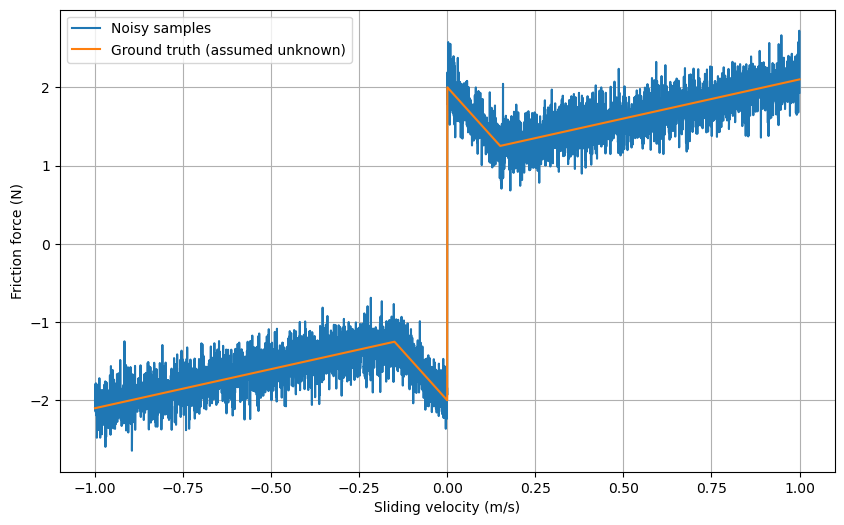

In [3]:
n_plot = 5000
xs_plot = np.linspace(-1, 1, n_plot)
_, ys_plot = create_dataset(n_plot, v=xs_plot)
_, ground_truth = create_dataset(n_plot, v=xs_plot, noise=False)
plt.plot(xs_plot, ys_plot, label='Noisy samples')
plt.plot(xs_plot, ground_truth, label='Ground truth (assumed unknown)')
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.legend()
plt.grid(True)

In the following we assume that we have access to a data set of $N=100$ points.

In [4]:
n_train = 100
xs_train, ys_train = create_dataset(n_train)

## Standard GP regression
We start with GP regression as introduced in the lecture. Consider a GP prior with zero mean and SE covariance function with lengthscale $\ell=0.25$ and signal variance $\sigma_\mathrm{f}^2=2$ as well as a Gaussian likelihood with noise variance $\sigma_\mathrm{n}^2=0.04$.

### Question (a)
**Question** Compute the posterior GP.

In [5]:
### BEGIN SOLUTION
class ExactGPmodel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPmodel, self).__init__(train_x, train_y, likelihood)
        
        #self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = gpytorch.means.ZeroMean()
        
        se_kernel = gpytorch.kernels.RBFKernel()
        #se_kernel.has_lengthscale = True
        #se_kernel.lengthscale = 0.1
        self.covar_module = gpytorch.kernels.ScaleKernel(se_kernel)
        #self.covar_module = se_kernel
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

xs_data = torch.from_numpy(xs_train)
ys_data = torch.from_numpy(ys_train)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPmodel(xs_data, ys_data, likelihood)
model.likelihood.noise = 0.04
model.covar_module.outputscale = 2
model.covar_module.base_kernel.lengthscale = 0.25
### END SOLUTION

**Question** Plot the posterior mean together with the ground truth and the data set. Visualize the 95% confidence interval, i.e., the posterior mean +/- 1.96$\times$ posterior SD.

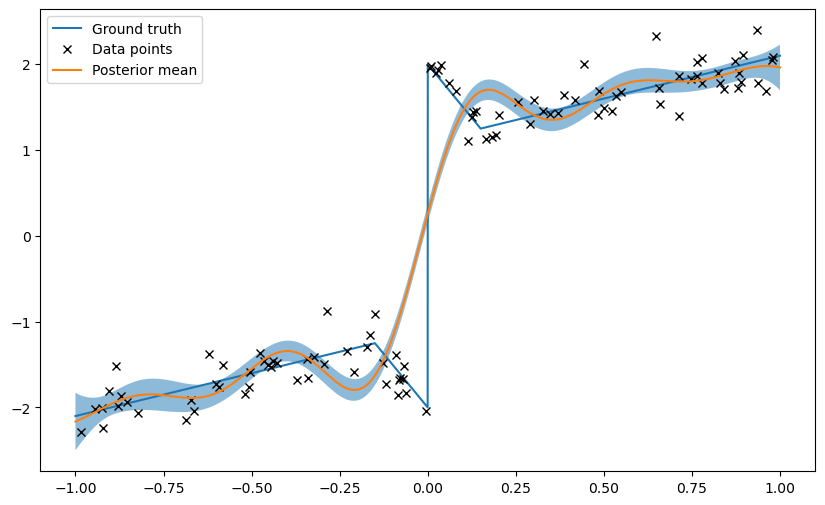

In [6]:
### BEGIN SOLUTION
xs = torch.from_numpy(xs_plot)

with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.plot(xs_plot, ground_truth, label='Ground truth')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs_plot, f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
### END SOLUTION

**Additional Question** Perform hyperparameter tuning and plot the result.

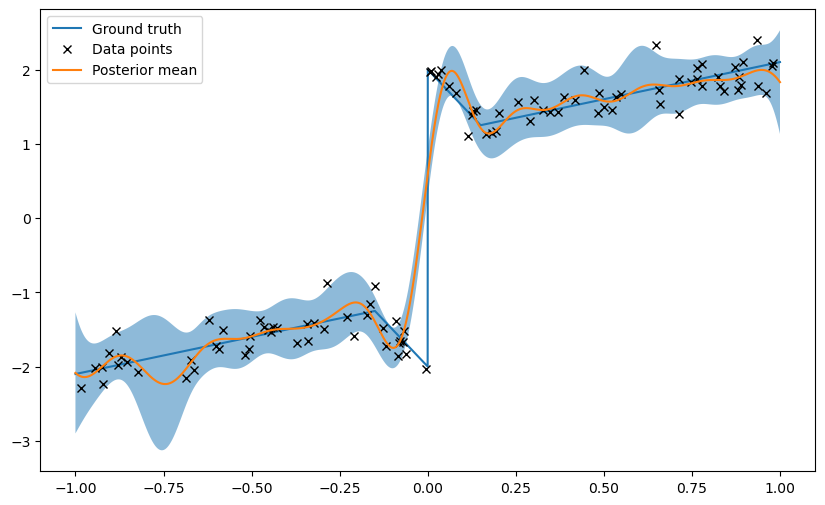

In [7]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(100):
    optimizer.zero_grad()
    output = model(xs_data)
    loss= -mll(output, ys_data)
    loss.backward()
    optimizer.step()


with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.figure()
    plt.plot(xs_plot, ground_truth, label='Ground truth')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs_plot, f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();

So far our GP model is unsatisfactory. This is not surprising, since the SE kernel leads to very smooth sample paths (and posterior mean), and therefore it is particularly ill-suited to model the discontinuity in the data.

It is reasonable to assume that the presence of this discontinuity can be inferred from prior domain knowledge. We now incorporate this into our model. The simplest approach is to change the mean function appropriately.

### Question (b)
Consider a new prior mean function $m(x)=2\phi(x)$ where $\phi:\mathbb{R}\rightarrow\mathbb{R}$ is the sign function defined by
$$
\phi(x) = 
\begin{cases}
1 & \text{if } x \geq 0 \\
0 & \text{if } x=0 \\
-1 & \text{otherwise}
\end{cases}
$$
Implement the new mean function $m$. Compute the posterior and plot it as in the previous question.

Explain why this solves the issue identified in the previous question by using the result of Problem Set 4, Problem 5.d.

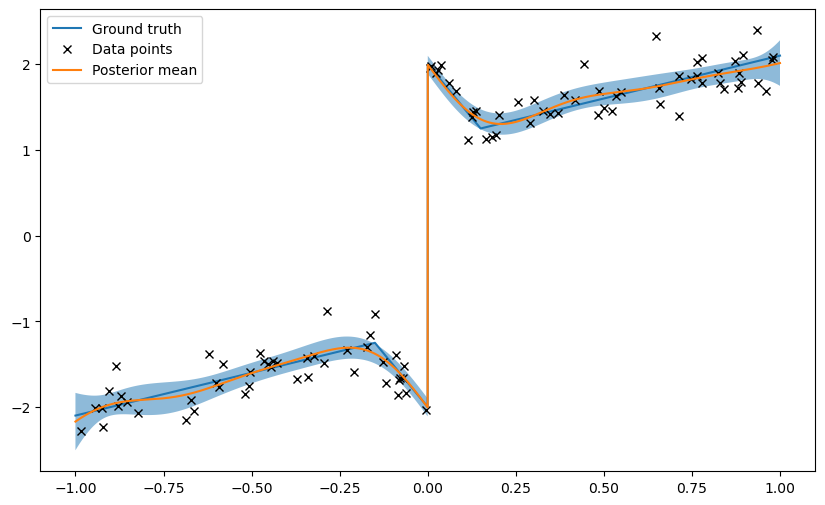

In [8]:
### BEGIN SOLUTION
# The new mean function
class StepMean(gpytorch.means.Mean):
    def __init__(self, jump_size=None):
        super(StepMean, self).__init__()
        if jump_size is None:
            jump_size = 1
        self.jump_size = jump_size
        
    def forward(self, input):
        return self.jump_size*torch.sign(input).squeeze()
    
# Setting up the model and computing the posterior
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPmodel(xs_data, ys_data, likelihood)
model.mean_module = StepMean(jump_size=2)

model.likelihood.noise = 0.04
model.covar_module.outputscale = 2
model.covar_module.base_kernel.lengthscale = 0.25

# Plotting
with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.plot(xs_plot, ground_truth, label='Ground truth')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs_plot, f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
### END SOLUTION

### Question (c)
Re-do the previous question with $m'= \frac 12 m$ instead. What do you observe? Comment.

_In Exercise Session 14, the notebook used contained two inaccuracies: First, contrary to the exercise instructions a jump size of 1/2 instead of 1/2*2=1 was used. Second, the update of the prior mean was not done properly. Here is the corrected version, the conclusion and general observation of this task hold up._

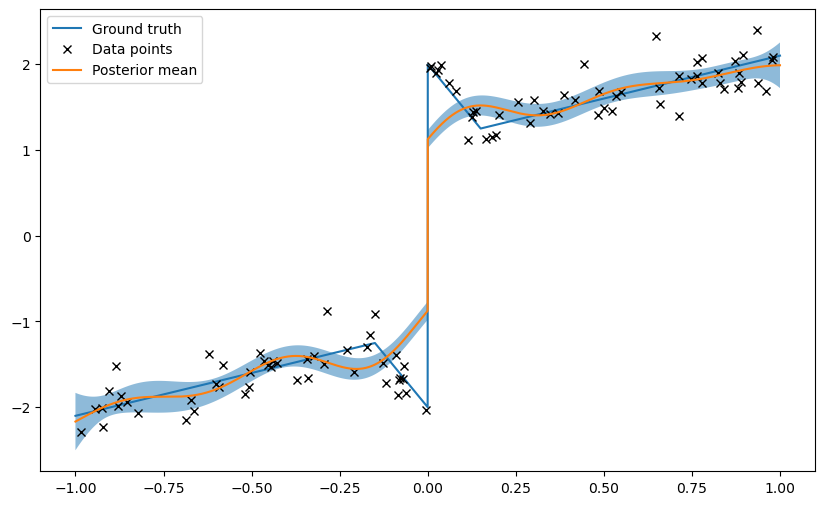

In [9]:
### BEGIN SOLUTION
model = ExactGPmodel(xs_data, ys_data, likelihood)
model.mean_module = StepMean(jump_size=1)

model.likelihood.noise = 0.04
model.covar_module.outputscale = 2
model.covar_module.base_kernel.lengthscale = 0.25

with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.plot(xs_plot, ground_truth, label='Ground truth')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs_plot, f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
### END SOLUTION

### Question (d)
Perform linear regression to fit the parameter $w$ and model the residual of this model with the
0-mean GP $f$. What do you observe? Comment.

_Similar to Question (c), the change of the prior mean was not done properly in the notebook shown in Exercise Session 14. Here is the corrected version._

w_LS=1.681


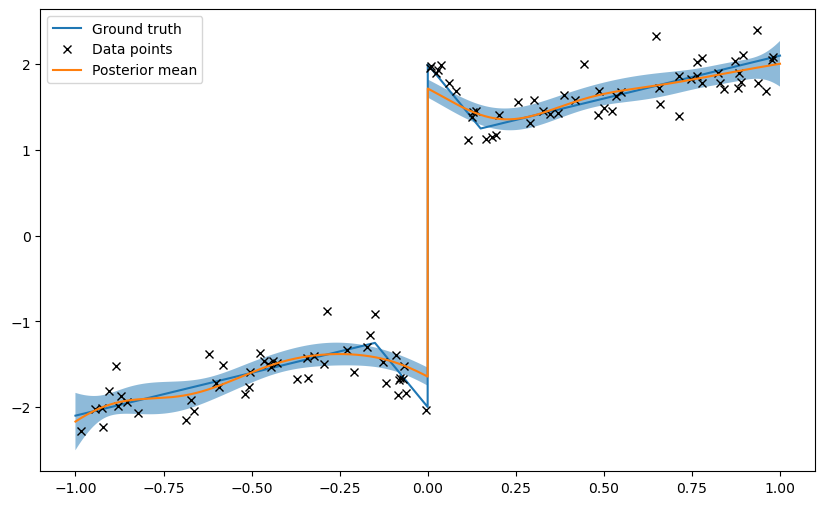

In [10]:
### BEGIN SOLUTION
Phi = np.sign(xs_train)
w_ls = 1/np.dot(Phi,Phi)*np.dot(Phi, ys_train)
print(f'w_LS={w_ls:.3f}')

model = ExactGPmodel(xs_data, ys_data, likelihood)
model.mean_module = StepMean(jump_size=w_ls)

model.likelihood.noise = 0.04
model.covar_module.outputscale = 2
model.covar_module.base_kernel.lengthscale = 0.25

with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.plot(xs_plot, ground_truth, label='Ground truth')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs_plot, f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
### END SOLUTION

### Question (e)
Implement the semiparametric regression model developed in Question (d) in the problem.
Choose $\bar w= 0$ and $\sigma=1$ as well as the other hyperparameters as specified in Question (a).

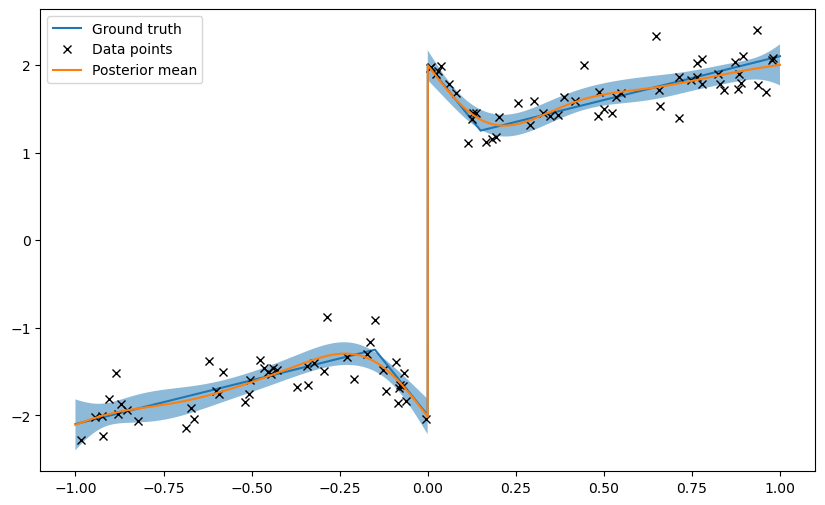

In [11]:
### BEGIN SOLUTION
# We introduce a new covariance function to implement the semiparametric model
class StepKernel(gpytorch.kernels.Kernel):
    def forward(self, x1, x2, **params):
        return torch.sign(x1)*torch.sign(x2.transpose(-2,-1))
    
# This class implements the semiparametric model
class ExactSemiparamGPmodel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactSemiparamGPmodel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()

        se_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        step_kernel = gpytorch.kernels.ScaleKernel(StepKernel())
        self.covar_module = gpytorch.kernels.AdditiveKernel(se_kernel, step_kernel)
        #self.covar_module = se_kernel
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Setup of the model and computing the posterior
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactSemiparamGPmodel(xs_data, ys_data, likelihood)

model.likelihood.noise = 0.04
model.covar_module.kernels[0].output_scale = 2
model.covar_module.kernels[0].base_kernel.lengthscale = 0.25
model.covar_module.kernels[1].output_scale = 1

# Plotting
with torch.no_grad():
    model.eval()
    f_pred = model(xs)
    lower, upper = f_pred.confidence_region()
    
    plt.plot(xs_plot, ground_truth, label='Ground truth')
    plt.plot(xs_data, ys_data, 'kx', label='Data points')
    plt.plot(xs_plot, f_pred.mean.numpy(), label='Posterior mean')
    #plt.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.fill_between(xs.numpy(),
                     (f_pred.mean - 1.96*f_pred.stddev).numpy(),
                     (f_pred.mean + 1.96*f_pred.stddev).numpy(),
                     alpha=0.5)
    plt.legend();
    
### END SOLUTION